In [ ]:
import numpy as np
import pandas as pd
from google.colab import drive
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [ ]:
drive.mount('/content/drive')

MessageError: ignored

# Getting the Data

I had each dataset in my google drive, if you want to run this you will need to create a copy of each dataset in your drive or change the paths.

In [ ]:
coordinatePath = "/content/drive/MyDrive/coordinates.csv"
coords = pd.read_csv(coordinatePath, header=None)
coords.columns = coords.iloc[0,:]
coords = coords.iloc[1:, :]
coords.iloc[:,1:] = coords.iloc[:,1:].astype(float)

dataPath = "/content/drive/MyDrive/Measured_data.csv"
df = pd.read_csv(dataPath, header=None)
df.columns = df.iloc[0,:]
df = df.iloc[1:, :]
df.iloc[:,2:] = df.iloc[:,2:].astype(float)
for i in range(0, 197):
  vals = df.iloc[i, 1].split('-')
  df.iloc[i, 1] = (float(vals[0]) + float(vals[1])) / 2.0
  df.iloc[i,0] = df.iloc[i,0].split('-')[0]

visNirPath = "/content/drive/MyDrive/Vis-NIR_Reflectance.csv"
visNIR = pd.read_csv(visNirPath, header=None)
visNIR.columns = visNIR.iloc[0,:]
visNIR = visNIR.iloc[1:, :]
visNIR.iloc[:,2:] = visNIR.iloc[:,2:].astype(float)
for i in range(0, 2241):
  vals = visNIR.iloc[i, 1].split('-')
  visNIR.iloc[i, 1] = (float(vals[0]) + float(vals[1])) / 2.0
  visNIR.iloc[i,0] = visNIR.iloc[i,0].split('-')[0]

FileNotFoundError: ignored

# Creating a location plot with pH

First, I wanted to see if pH was location-based. I standardized the longitude, latitude, and pH because there were such minute differences in the data and I wanted to see relative change.

In [ ]:
averages = df.copy(deep=True)
averages = averages.groupby(['ID'], as_index=False).mean()
averages = averages.merge(coords, on='ID', how='left')
averages['pH'] = ((averages['pH'] - averages['pH'].mean()) / averages['pH'].std()) * 10
averages['lat'] = ((averages['lat'] - averages['lat'].mean()) / averages['lat'].std()) * 10
averages['lon'] = ((averages['lon'] - averages['lon'].mean()) / averages['lon'].std()) * 10
print(averages)



0      ID      Depth         pH   Clay (%)   Silt (%)   Sand (%)   SOC (%)  \
0   OB100  39.875000   3.046254  20.500000  31.250000  48.125000  0.419767   
1    OB12  34.785714   1.734620  14.857143  17.285714  67.857143  0.558678   
2    OB13  44.777778   7.532159  18.111111  40.111111  41.888889  0.651828   
3    OB19  40.250000   4.630994  20.125000  35.500000  44.125000  0.513052   
4     OB2  35.071429  24.301899  16.714286  29.857143  53.000000  5.816287   
5    OB20  44.777778  -9.505897  16.888889  24.222222  59.000000  0.590845   
6    OB25  39.937500  10.894492  17.000000  18.375000  64.625000  0.662883   
7    OB28  40.312500   2.165842  21.750000  33.750000  44.375000  1.156444   
8    OB38  44.833333  -2.976878  17.444444  35.888889  46.444444  0.633359   
9    OB44  35.428571  -1.140192  10.571429  14.000000  75.571429  0.291420   
10   OB46  40.250000   0.430174  18.875000  29.500000  51.750000  0.771486   
11   OB47  39.875000  -7.619301  10.500000  11.625000  77.750000

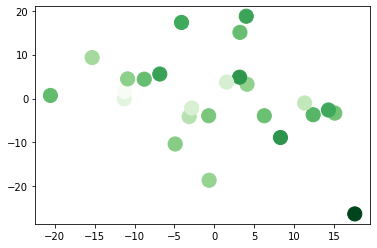

In [ ]:
plt.scatter(averages['lat'], averages['lon'], c=averages['pH'], cmap='Greens', s=200)
plt.show()

It seems that pH is not hugely dependent on location, so I will ignore it when creating models (for rn).

# Creating Models Without Vis-NIR Data


In [ ]:
X = df.iloc[:, [1,3,4,5,6,7]]
y = df.iloc[:, 2]

models performed better when scaling

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

NameError: ignored

In [ ]:
X_train, X_tmp, y_train, y_tmp = train_test_split(X_scaled, y, test_size=.2, random_state=0)
X_valid, X_test, y_valid, y_test = train_test_split(X_tmp, y_tmp, test_size=.5, random_state=0)

easy to add more models, but this is what I started with.

In [ ]:
classifiers = [GradientBoostingRegressor(random_state=0), RandomForestRegressor(), KNeighborsRegressor()]
gradientParameters = {'n_estimators': [10, 50, 100, 150], 'learning_rate': [0.01, 0.25, 1, 1.3], 'max_depth': [1,2]}
RandomForestParameters = {'n_estimators': [10,50,100,200],'max_depth': [1, 2, 3, 4, 5]}
KNNParameters = {'n_neighbors': [1, 2, 3, 4]}
parameters = [gradientParameters, RandomForestParameters, KNNParameters]

In [ ]:
bestClassifierIndex = -1
bestMSE = np.Inf
bestClassifier = None
for i in range(0, 3):
  print(i, "...", sep="")
  clf = GridSearchCV(classifiers[i], parameters[i])
  clf.fit(X_train, y_train)

  score = mean_squared_error(y_valid, clf.predict(X_valid))
  if score < bestMSE:
    bestClassifierIndex = i
    bestClassifier = clf
    bestMSE = score

0...


NameError: ignored

In [ ]:
print("Best MSE: ", bestMSE)
print("Best Classifier Index: ", bestClassifierIndex)
print("Best Classifier: ", bestClassifier)
bestGuess = list(bestClassifier.predict(X_test))
y_test = list(y_test)
correct = 0
for i in range(0, 20):
  if round(bestGuess[i]) == round(y_test[i]):
    correct = correct + 1
print(correct, " out of 20 are correct.")

Best MSE:  0.5246024447497667
Best Classifier Index:  1
Best Classifier:  GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_depth': [1, 2, 3, 4, 5],
                         'n_estimators': [10, 50, 100, 200]})
12  out of 20 are correct.


I figured guessing the actual pH value rounded was a good estimator of model success. In actuality, most of the model's predictions were ~1 away in either direction. I did not add Vis-NIR data because frankly, I don't understand what the data actually is.